### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of 9 timeseries of float values, each of length 128.

The 9 timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
# Useful Constants
TRAIN = "UCI-HAR-Dataset/train/"
TEST = "UCI-HAR-Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

In [5]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    '''
    For the given label y (0<=y<n_classes) create a one-hot vector of lenght n_classes.
    '''
    ### START YOUR CODE 
    v = np.zeros(n_classes);
    vector = []
    for i in y:
        v = np.zeros(n_classes);
        v[i] = 1
        vector.append(list(v))
    return np.array(vector)
    
    ### END YOUR CODE 

def label_from_onehot(vectors):
    '''
    For given list of vectors of scores, create a list of (predicted) labels.
    '''
    ### START YOUR CODE 
    r = []
    for v in vectors:
        [r.append(i) for i,x in enumerate(v) if x == 1]
    return np.array(r)
    ### END YOUR CODE 

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)

In [6]:
# TESTING
labels = np.array(range(N_CLASSES))
np.testing.assert_equal(labels,label_from_onehot(one_hot(labels, N_CLASSES)))

In [7]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

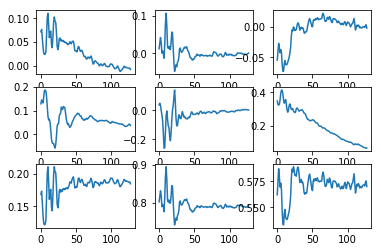

In [8]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[5], 1)

In [9]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series

print("(X shape, Y_shape, every X's mean, every X's standard deviation)")
print(X_train.shape, Y_train.shape, np.mean(X_train), np.std(X_train))
print(X_test.shape, Y_test.shape, np.mean(X_test), np.std(X_test))

(X shape, Y_shape, every X's mean, every X's standard deviation)
(7352, 128, 9) (7352, 6) 0.10206611 0.40216514
(2947, 128, 9) (2947, 6) 0.09913992 0.39567086


### Specify and Train the Model

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras.layers import LSTM, RNN, SimpleRNN, Dropout

from sklearn import metrics

### Single Layer RNN

Specify a model based on a <code>SimpleRNN</code> (<code>keras.layers.SimpleRNN</code>) followed by a softmax for the classification.

Try different number of units. Do hyper-parameter tuning and report the best test accuracy you can achieve. 

In [13]:
# create and compile model 
### START YOUR CODE 
n_steps = 128
n_input = 9

n_hidden = 40
n_classes = N_CLASSES

model = Sequential()
model.add(SimpleRNN(units=n_hidden, 
                    return_sequences=False, 
                    input_shape=(n_steps,n_input)))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### END YOUR CODE 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 40)                2000      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 2,246
Trainable params: 2,246
Non-trainable params: 0
_________________________________________________________________


In [14]:
# create and compile model 
### START YOUR CODE 
n_steps = 128
n_input = 9

n_hidden = 40
n_classes = N_CLASSES

model = Sequential()
model.add(LSTM(units=n_hidden, 
                    return_sequences=False, 
                    input_shape=(n_steps,n_input)))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### END YOUR CODE 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                8000      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 8,246
Trainable params: 8,246
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train the model
batch_size = 256
n_epochs = 20
log = model.fit(X_train,Y_train,
                epochs=n_epochs,
                verbose=1,
                batch_size=batch_size,
                validation_data=(X_test,Y_test)
                )

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 8s 1ms/step - loss: 1.6181 - acc: 0.4044 - val_loss: 1.4312 - val_acc: 0.4048
Epoch 2/20
7352/7352 [==============================] - 7s 921us/step - loss: 1.3365 - acc: 0.4323 - val_loss: 1.3109 - val_acc: 0.4659
Epoch 3/20
7352/7352 [==============================] - 8s 1ms/step - loss: 1.2001 - acc: 0.5143 - val_loss: 1.2461 - val_acc: 0.4350
Epoch 4/20
7352/7352 [==============================] - 8s 1ms/step - loss: 1.1855 - acc: 0.4739 - val_loss: 1.2851 - val_acc: 0.4683
Epoch 5/20
7352/7352 [==============================] - 11s 1ms/step - loss: 1.2057 - acc: 0.5473 - val_loss: 1.2636 - val_acc: 0.4829
Epoch 6/20
7352/7352 [==============================] - 7s 926us/step - loss: 1.1212 - acc: 0.5307 - val_loss: 1.1650 - val_acc: 0.5015
Epoch 7/20
7352/7352 [==============================] - 7s 920us/step - loss: 0.9665 - acc: 0.6119 - val_loss: 1.0092 - val_acc: 0.5860
Epoch 8

In [20]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

2947/2947 [==============================] - 3s 1ms/step
Test score: 0.6660112684000375
Test accuracy: 0.827621309806583


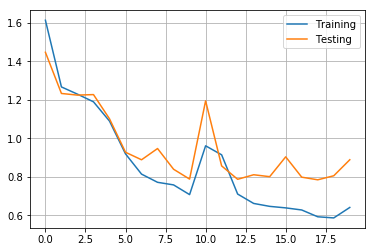

In [60]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

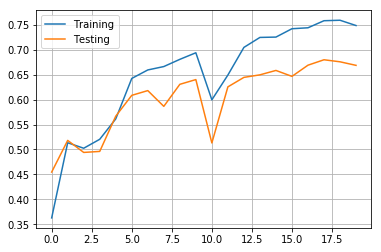

In [61]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.legend()
plt.grid()

In [62]:
# Compute the confusion matrix
### START YOUR CODE 
from sklearn import metrics as me

pred = model.predict_classes(X_test, verbose=1)
Y_test_labels = label_from_onehot(Y_test)

me.confusion_matrix(Y_test_labels, pred)
### END YOUR CODE 

2947/2947 [==============================] - 1s 442us/step


array([[106, 184, 143,  62,   1,   0],
       [ 61, 345,  45,  20,   0,   0],
       [100,  57, 223,  39,   1,   0],
       [  0,  23,   0, 416,  52,   0],
       [  0,  22,   0, 137, 373,   0],
       [  0,  28,   0,   2,   0, 507]])

### Add Regularisation

Implement L2-Regularisation for <code>SimpleRNN</code> (single layer) and the Softmax Layer. Investigate how you can do that in <code>keras</code>.

Implement Gradient Clipping. Find out how you can do that in <code>keras</code>.

In [17]:
# Specify model incl. L2 regularisation
from keras.regularizers import l2
from keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras import optimizers
from keras.callbacks import ModelCheckpoint

n_steps = 128
n_input = 9

n_hidden = 40
n_classes = N_CLASSES

model = Sequential()
model.add(LSTM(units=n_hidden, 
                    return_sequences=False, 
                    input_shape=(n_steps,n_input)))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
adam = optimizers.adam(clipnorm=0.8,clipvalue=0.2)   # Grad. clipping
checkpoint = ModelCheckpoint('model-{epoch:03d}',verbose=3,monitor='val_acc',save_best_only=True,mode='auto')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### END YOUR CODE 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40)                8000      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 246       
Total params: 8,246
Trainable params: 8,246
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Implement gradient clipping and train the model.
batch_size = 256
n_epochs = 30
log = model.fit(X_train,Y_train,
                epochs=n_epochs,
                verbose=1,
                batch_size=batch_size,
                validation_data=(X_test,Y_test),
                callbacks=[checkpoint]
                )

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 8s 1ms/step - loss: 1.7875 - acc: 0.3547 - val_loss: 1.5916 - val_acc: 0.3590

Epoch 00001: val_acc improved from -inf to 0.35901, saving model to model-001
Epoch 2/30
7352/7352 [==============================] - 7s 988us/step - loss: 1.4877 - acc: 0.3760 - val_loss: 1.4642 - val_acc: 0.3532

Epoch 00002: val_acc did not improve from 0.35901
Epoch 3/30
7352/7352 [==============================] - 5s 730us/step - loss: 1.3750 - acc: 0.4489 - val_loss: 1.3391 - val_acc: 0.4557

Epoch 00003: val_acc improved from 0.35901 to 0.45572, saving model to model-003
Epoch 4/30
7352/7352 [==============================] - 6s 868us/step - loss: 1.3113 - acc: 0.4593 - val_loss: 1.3118 - val_acc: 0.4686

Epoch 00004: val_acc improved from 0.45572 to 0.46861, saving model to model-004
Epoch 5/30
7352/7352 [==============================] - 5s 693us/step - loss: 1.1612 - acc: 0.5604 - val_loss: 1.198

In [21]:
# Evaluate the results by computing the accuracy and the confusion matrix.
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

2947/2947 [==============================] - 3s 963us/step
Test score: 0.6660112684000375
Test accuracy: 0.827621309806583


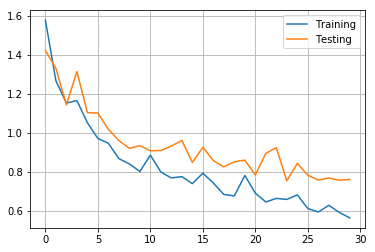

In [72]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

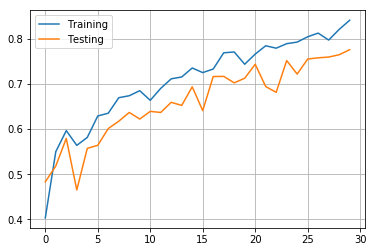

In [73]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.legend()
plt.grid()

In [74]:
from sklearn import metrics as me

pred = model.predict_classes(X_test, verbose=1)
Y_test_labels = label_from_onehot(Y_test)

me.confusion_matrix(Y_test_labels, pred)

2947/2947 [==============================] - 1s 471us/step


array([[414,   9,  50,  10,  13,   0],
       [119, 290,  45,   4,  13,   0],
       [137,   6, 276,   1,   0,   0],
       [  4,  14,   0, 341, 128,   4],
       [  3,   0,   0,  74, 455,   0],
       [  0,  27,   0,   1,   0, 509]])

### Stacked Layers

Specify a model based on stacked <code>SimpleRNN</code>'s (<code>keras.layers.SimpleRNN</code>) and a Softmax layer for the final classification. 

Again try different number of hidden units, do hyper-parameter tuning and report the best test accuracy you can achieve with two layers. 

In [22]:
n_steps = 128
n_input = 9
n_hidden1 = 40
n_hidden2 = 40
n_classes = 6
### START YOUR CODE 

model = Sequential()
model.add(LSTM(units=n_hidden, 
                    return_sequences=True, 
                    input_shape=(n_steps,n_input)))
model.add(Dropout(0.2))
model.add(LSTM(units=n_hidden2, 
                    return_sequences=False))
model.add(Dense(32, 
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)
                ))
model.add(Dense(n_classes, 
                activation='softmax',
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)
                ))
adam = optimizers.adam(clipnorm=0.8,clipvalue=0.2)   # Grad. clipping
checkpoint = ModelCheckpoint('model-{epoch:03d}',verbose=1,monitor='val_acc',save_best_only=True,mode='auto')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### END YOUR CODE 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 22,470
Trainable params: 22,470
Non-trainable params: 0
_________________________________________________________________


In [23]:
batch_size = 256
n_epochs = 30
log = model.fit(X_train,Y_train,
                epochs=n_epochs,
                verbose=1,
                batch_size=batch_size,
                validation_data=(X_test,Y_test),
                callbacks=[checkpoint]
                )

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 16s 2ms/step - loss: 4.6193 - acc: 0.4057 - val_loss: 4.3432 - val_acc: 0.3661

Epoch 00001: val_acc improved from -inf to 0.36614, saving model to model-001
Epoch 2/30
7352/7352 [==============================] - 12s 2ms/step - loss: 4.2071 - acc: 0.4538 - val_loss: 4.0425 - val_acc: 0.4771

Epoch 00002: val_acc improved from 0.36614 to 0.47710, saving model to model-002
Epoch 3/30
7352/7352 [==============================] - 12s 2ms/step - loss: 3.9075 - acc: 0.5521 - val_loss: 3.8169 - val_acc: 0.5752

Epoch 00003: val_acc improved from 0.47710 to 0.57516, saving model to model-003
Epoch 4/30
7352/7352 [==============================] - 12s 2ms/step - loss: 3.6514 - acc: 0.6413 - val_loss: 3.6044 - val_acc: 0.6257

Epoch 00004: val_acc improved from 0.57516 to 0.62572, saving model to model-004
Epoch 5/30
7352/7352 [==============================] - 12s 2ms/step - loss: 3.4913 - a

In [24]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

2947/2947 [==============================] - 5s 2ms/step
Test score: 0.808041618154095
Test accuracy: 0.9002375296912114


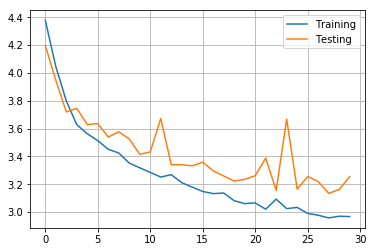

In [80]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

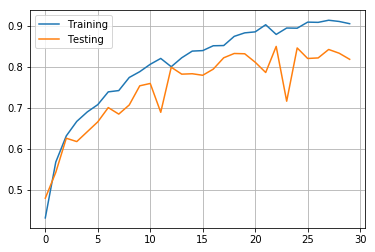

In [81]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.legend()
plt.grid()

In [82]:
# Evaluate the results by computing the accuracy and the confusion matrix.
from sklearn import metrics as me

pred = model.predict_classes(X_test, verbose=1)
Y_test_labels = label_from_onehot(Y_test)

me.confusion_matrix(Y_test_labels, pred)

2947/2947 [==============================] - 3s 1ms/step


array([[468,   3,  24,   0,   0,   1],
       [106, 340,  25,   0,   0,   0],
       [ 70,   0, 350,   0,   0,   0],
       [  7,  19,   0, 409,  56,   0],
       [  1,  82,   0, 114, 335,   0],
       [  0,  26,   1,   0,   0, 510]])